In [216]:
!pip install -U imblearn

In [217]:
import os
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.over_sampling import SMOTENC, SVMSMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
# torch api
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
from torchsummary import summary
from sklearn.impute import SimpleImputer
# device add gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")       # 使用Nvidia 顯卡
device

device(type='cpu')

## 讀取資料集

In [218]:
# 讀取數據
data_train = pd.read_csv('./data/train.csv', index_col=False)

In [219]:
data_train

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,61676,Male,77.0,0,0,Yes,Self-employed,Urban,68.38,25.1,Unknown,0
1,56923,Male,52.0,1,0,Yes,Private,Rural,116.21,32.8,smokes,0
2,48265,Male,65.0,0,0,Yes,Govt_job,Rural,111.85,26.7,never smoked,0
3,11843,Female,65.0,0,0,Yes,Self-employed,Rural,80.42,29.4,formerly smoked,0
4,57917,Female,47.0,0,0,Yes,Private,Urban,157.01,26.1,smokes,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4083,8719,Male,12.0,0,0,No,children,Urban,116.25,16.4,formerly smoked,0
4084,56282,Male,13.0,0,0,No,Private,Rural,90.60,16.9,never smoked,0
4085,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
4086,66196,Male,75.0,0,1,No,Private,Rural,201.76,30.2,formerly smoked,0


In [220]:
data_test = pd.read_csv("./data/test.csv", index_col=False)

In [221]:
data_train.info()
# data_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4088 entries, 0 to 4087
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4088 non-null   int64  
 1   gender             4088 non-null   object 
 2   age                4088 non-null   float64
 3   hypertension       4088 non-null   int64  
 4   heart_disease      4088 non-null   int64  
 5   ever_married       4088 non-null   object 
 6   work_type          4088 non-null   object 
 7   Residence_type     4088 non-null   object 
 8   avg_glucose_level  4088 non-null   float64
 9   bmi                3928 non-null   float64
 10  smoking_status     4088 non-null   object 
 11  stroke             4088 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 383.4+ KB


In [222]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1022 non-null   int64  
 1   gender             1022 non-null   object 
 2   age                1022 non-null   float64
 3   hypertension       1022 non-null   int64  
 4   heart_disease      1022 non-null   int64  
 5   ever_married       1022 non-null   object 
 6   work_type          1022 non-null   object 
 7   Residence_type     1022 non-null   object 
 8   avg_glucose_level  1022 non-null   float64
 9   bmi                981 non-null    float64
 10  smoking_status     1022 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 88.0+ KB


缺失值檢測
重點關注 Non-Null Count：

- 如果某欄位的 Non-Null Count < 總筆數，表示有缺失值
- 例如：bmi: 981 non-null，表示 bmi 欄位有 1022 - 981 = 41 個缺失值

## 資料清理與前處理

In [223]:
# 數據預處理
def preprocess_data(data):
    # 複製數據
    df = data.copy()
    
    # 處理缺失值 - BMI
    if df['bmi'].isnull().sum() > 0:
        imputer = SimpleImputer(strategy='median')
        df['bmi'] = imputer.fit_transform(df[['bmi']])
    
    # 根據風險因子創建特徵工程
    # 1. 年齡分組 (0-18, 18-35, 36-50, 51-65, >65)
    df['age_group'] = pd.cut(df['age'], 
                            bins=[0, 18, 35, 50, 65, 100], 
                            labels=['<18', '18-35', '36-50', '51-65', '>65'])
    
    # 2. 高風險年齡標記(65歲以上)
    df['high_risk_age'] = (df['age'] >= 65).astype(int)
    
    # 3. BMI分組(根據WHO標準)
    # BMI 分組: <18.5 (underweight), 18.5-24.9 (normal), 25-29.9 (overweight), >=30 (obese)
    df['bmi_group'] = pd.cut(df['bmi'], 
                            bins=[0, 18.5, 25, 30, 100], 
                            labels=['underweight', 'normal', 'overweight', 'obese'])
    
    # 4. 血糖分組(根據WHO標準)
    # 血糖分組: <100 (normal), 100-125 (prediabetes), 126-200 (diabetes), >200 (high)
    df['glucose_group'] = pd.cut(df['avg_glucose_level'], 
                                bins=[0, 100, 126, 200, 400], 
                                labels=['normal', 'prediabetes', 'diabetes', 'high'])
    
    # 5. 多重風險因子組合(高血壓 + 心臟病 + 高風險年齡)
    df['multiple_risks'] = (df['hypertension'] + df['heart_disease'] + df['high_risk_age']).astype(int)
    
    # 6. 慢性病組合(高血壓 + 心臟病)
    df['chronic_diseases'] = (df['hypertension'] + df['heart_disease']).astype(int)
    

    return df

# 編碼類別特徵
def encode_categorical_features(train_df, test_df):
    
    # 需要編碼的類別特徵
    categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 
                           'smoking_status', 'age_group', 'bmi_group', 'glucose_group']
    
    # 使用 get_dummies 進行 one-hot encoding, 確保 dtype 一致
    train_encoded = pd.get_dummies(train_df, columns=categorical_features, prefix=categorical_features, dtype=int)
    test_encoded = pd.get_dummies(test_df, columns=categorical_features, prefix=categorical_features, dtype=int)
    
    # 獲取所有特徵(確保訓練和測試數據有相同的特徵)
    all_features = set(train_encoded.columns) | set(test_encoded.columns)
    
    # 為缺失的特徵添加零列
    for feature in all_features:
        if feature not in train_encoded.columns:
            train_encoded[feature] = 0
        if feature not in test_encoded.columns:
            test_encoded[feature] = 0
    
    # 確保列順序相同
    feature_order = sorted([col for col in train_encoded.columns if col not in ['id', 'stroke']])
    
    return train_encoded, test_encoded, feature_order

# 標準化數值特徵
def standardize_features(X_train, X_val, X_test, numerical_features=None):
    """
    對數值特徵進行標準化
    """
    if numerical_features is None:
        # 自動識別數值特徵（浮點數類型的欄位）
        numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
    # 初始化標準化器
    scaler = StandardScaler()
    
    # 複製資料避免修改原始資料
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()
    
    # 使用訓練資料擬合標準化器，並轉換所有資料集
    X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
    X_val_scaled[numerical_features] = scaler.transform(X_val[numerical_features])
    X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])
    
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

# 預處理訓練和測試數據
train_processed = preprocess_data(data_train)
test_processed = preprocess_data(data_test)

# 編碼類別變數
train_encoded, test_encoded, feature_order = encode_categorical_features(train_processed, test_processed)

# 準備訓練數據
X_features = train_encoded[feature_order]  # 特徵資料
y_stroke = train_encoded['stroke']         # 中風目標

# 準備測試數據
X_test = test_encoded[feature_order]

## 切分資料集 (train, val, test)

In [224]:
# 使用訓練資料 - 分割訓練和驗證集
X_train, X_val, y_train, y_val = train_test_split(
    X_features, y_stroke, 
    test_size=0.2, 
    random_state=2610, 
    stratify=y_stroke
)

# 進行標準化
X_train_scaled, X_val_scaled, X_test_scaled, scaler = standardize_features(
    X_train, X_val, X_test,
    numerical_features=['age', 'avg_glucose_level', 'bmi'] # 只標準化連續變數
)

print("原始資料形狀:", X_train.shape, X_val.shape, y_train.shape, y_val.shape)
print("標準化後資料形狀:", X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)
print("數值特徵標準化完成")

# 檢查資料類型
print("標準化後資料類型:")
print("X_train_scaled dtypes:", X_train_scaled.dtypes.value_counts())
print("是否有 NaN 值:", X_train_scaled.isnull().sum().sum())

原始資料形狀: (3270, 37) (818, 37) (3270,) (818,)
標準化後資料形狀: (3270, 37) (818, 37) (1022, 37)
數值特徵標準化完成
標準化後資料類型:
X_train_scaled dtypes: int64      34
float64     3
Name: count, dtype: int64
是否有 NaN 值: 0


各變數意義：
- X_train：訓練集的特徵資料
- X_val：驗證集的特徵資料
- y_train：訓練集的標籤資料
- y_val：驗證集的標籤資料

## 建立模型

In [225]:
## 建立訓練的 generator ，簡單來說因為資料量可能會偏大，所以使用generator可以將所有資料分成n筆資料訓練一次。
class Custom_Generator(Dataset):
    def __init__(self, X_data, y_data):
        # 確保資料是 numpy array 格式
        if hasattr(X_data, 'values'):
            self.X_data = X_data.values.astype(np.float32)
        else:
            self.X_data = np.array(X_data, dtype=np.float32)
            
        if hasattr(y_data, 'values'):
            self.y_data = y_data.values.astype(np.int64)
        else:
            self.y_data = np.array(y_data, dtype=np.int64)

    def __getitem__(self, index):
        data = self.X_data[index] # 取得第 index 筆特徵資料
        target = self.y_data[index]  # 取得第 index 筆標籤資料
        
        # 轉換為 tensor
        data = torch.FloatTensor(data) # 特徵轉為浮點數 tensor
        target = torch.LongTensor([target]).squeeze() # 標籤轉為長整數 tensor

        return data, target

    def __len__(self):
        return len(self.X_data)     # 回傳資料集數量

特徵資料用 FloatTensor：
- 適合數值計算和梯度更新
- 與模型權重的資料型態一致

標籤資料用 LongTensor：
- CrossEntropyLoss 需要整數類別標籤
- 分類問題的標準格式

In [226]:
# 由於我們的輸入資料的維度一定是(batch, input)，所以要將維度改成二維資料
# 使用標準化後的資料
if hasattr(X_train_scaled, 'values'):
    input_x = X_train_scaled.values.astype(np.float32)
else:
    input_x = np.array(X_train_scaled, dtype=np.float32)

# 確保 y_train 是 numpy array
if hasattr(y_train, 'values'):
    target_y = y_train.values.astype(np.int64)
else:
    target_y = np.array(y_train, dtype=np.int64)

# 1. 先呼叫我們寫好的Custom_Generator
train_data = Custom_Generator(X_data = input_x, y_data = target_y)

# 2. 呼叫pytorch的DataLoader來做批次動作，模型的輸入
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)  # 建議增加 batch_size

## 解決 Overfitting 問題

從訓練曲線圖來看，訓練集的準確率（Training Accuracy）遠高於驗證集（Testing Accuracy），且驗證集的損失（Testing Loss）在訓練過程中不斷上升，這是典型的 **Overfitting（過度擬合）** 現象。

為了解決這個問題，我們將採用以下幾種策略來增強模型的泛化能力：

1.  **增加 Dropout Rate**：將 Dropout 的比例從 `0.3` 提高到 `0.5`。這會讓神經網路在訓練時隨機「關閉」更多的神經元，迫使網路學習到更穩健的特徵，減少對訓練資料的依賴。
2.  **加入 Batch Normalization**：在每個全連接層之後、激活函數之前加入批次標準化層 (`BatchNorm1d`)。這有助於穩定網路的學習過程，並帶來輕微的正則化效果。
3.  **加入 L2 正則化 (Weight Decay)**：在優化器中設定 `weight_decay` 參數。這會對模型的權重大小進行懲罰，防止權重過大，從而降低模型複雜度。

接下來我們將修改模型架構和優化器來實現這些策略。

In [227]:
## 請建立屬於自己的模型
class DNN(nn.Module):
    def __init__(self, input_shape):
        super(DNN, self).__init__()
        
        # 定義網路層
        self.fc1 = nn.Linear(input_shape, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 2)  # 二元分類: 0(無中風), 1(中風)
        
        # Dropout層防止過度配適
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 第一層
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # 第二層
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # 第三層
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # 輸出層
        x = self.fc4(x)
        
        return x

In [228]:
# 使用標準化後的資料來建立模型
model = DNN(input_shape=X_train_scaled.shape[1]).to(device)
print(model)
summary(model, input_size=(X_train_scaled.shape[1],))

DNN(
  (fc1): Linear(in_features=37, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           4,864
       BatchNorm1d-2                  [-1, 128]             256
           Dropout-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
       BatchNorm1d-5                   [-1, 64]         

In [229]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 計算平衡的類別權重
class_weights = compute_class_weight(
    class_weight='balanced',           # 自動平衡權重
    classes=np.unique(y_train),       # 所有類別 [0, 1]
    y=y_train                         # 訓練標籤
)

# 將 class_weights 轉換為 tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

## 請設定模型需要的 loss、learning rate、epoch、optimizer

In [230]:
# 設定loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
# 降低學習率
learning_rate = 0.0005
# epochs數量
epochs = 100
# 優化器 - 進一步增強 L2 正則化
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)

### 存下模型

In [231]:
folder = 'save_model'
if not os.path.exists(folder):
    os.mkdir(folder)

model_path = './save_model/checkpoints_model.pth'  # 模型儲存的位置

In [232]:
## 學習率排程器 - 更頻繁的衰減
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

In [233]:
def Train_Process(model, epochs, optimizer, criterion, l1_rate, trainloader, testloader, model_path):
    Train_loss = []
    Train_acc = []
    valid_loss = []
    valid_acc = []
    lr_rate = []
    Best_acc = 0
    
    # 早停機制參數
    patience = 15  # 容忍驗證損失不改善的 epoch 數
    min_valid_loss = float('inf')
    patience_counter = 0

    # 第1步驟
    for epoch in range(epochs):
        # 訓練階段
        model.train()  # 設定為訓練模式
        running_loss = 0.0
        accuracy = 0
        total = 0

        # 第2步驟
        for times, data_train in enumerate(trainloader, 0):
            # batch data input
            inputs, labels = data_train
            inputs = inputs.float().to(device)
            labels = labels.long().to(device)

            # 第3步驟
            optimizer.zero_grad()
            
            # model Feedforward
            outputs = model(inputs)

            # 第4步驟
            loss = criterion(outputs, labels)

            # 第5步驟
            loss.backward()

            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # 第6步驟
            optimizer.step()

            # Compute loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

            if times+1 == len(trainloader):
                print('[%d/%d, %d/%d] loss: %.3f, acc: %.3f,' % (epoch+1,
                                                                 epochs,
                                                                 times+1,
                                                                 len(trainloader),
                                                                 running_loss/len(trainloader),
                                                                 accuracy / total),end = " ")
                Train_loss.append(running_loss/len(trainloader))
                Train_acc.append(accuracy / total)

        # 測試階段
        model.eval()
        valid_running_loss = 0.0
        valid_accuracy = 0
        valid_total = 0

        with torch.no_grad():
            for times, data_test in enumerate(testloader, 0):
                inputs, labels = data_test
                inputs = inputs.float().to(device)
                labels = labels.long().to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_accuracy += (predicted == labels).sum().item()

                if times+1 == len(testloader):
                    current_lr = optimizer.param_groups[0]['lr']
                    lr_rate.append(current_lr)
                    
                    current_valid_loss = valid_running_loss/len(testloader)
                    current_valid_acc = valid_accuracy / valid_total
                    
                    valid_loss.append(current_valid_loss)
                    valid_acc.append(current_valid_acc)
                    
                    print('valid_loss: %.3f, valid_acc: %.3f, lr: %.6f' % (
                        current_valid_loss,
                        current_valid_acc,
                        current_lr
                    ))
                    
                    # 保存最佳模型
                    if current_valid_acc > Best_acc:
                        Best_acc = current_valid_acc
                        torch.save(model.state_dict(), model_path)
                        print(f'*** Best model saved with accuracy: {Best_acc:.3f} ***')
                    
                    # 早停機制
                    if current_valid_loss < min_valid_loss:
                        min_valid_loss = current_valid_loss
                        patience_counter = 0
                    else:
                        patience_counter += 1
                    
                    if patience_counter >= patience:
                        print(f'\n*** Early stopping triggered at epoch {epoch+1} ***')
                        return Train_loss, Train_acc, valid_loss, valid_acc, lr_rate
                    
                    # 更新學習率
                    if 'scheduler' in globals():
                        scheduler.step()

    return Train_loss, Train_acc, valid_loss, valid_acc, lr_rate

In [234]:
# 建立驗證資料的 DataLoader - 使用標準化後的資料
# 確保資料格式正確
if hasattr(X_val_scaled, 'values'):
    input_x_val = X_val_scaled.values.astype(np.float32)
else:
    input_x_val = np.array(X_val_scaled, dtype=np.float32)

# 確保沒有無窮大值或 NaN
input_x_val = np.where(np.isfinite(input_x_val), input_x_val, 0)

val_data = Custom_Generator(X_data = input_x_val, y_data = y_val)
testloader = DataLoader(val_data, batch_size=32, shuffle=False)  # 增加 batch_size 提升效率

Train_loss, Train_acc, valid_loss, valid_acc, lr_rate = Train_Process(model = model,
                                                             epochs = epochs,
                                                             optimizer = optimizer,
                                                             criterion = criterion,
                                                             l1_rate = 0,  # 不使用L1正則化
                                                             trainloader = trainloader,
                                                             testloader = testloader,
                                                             model_path = model_path)

[1/100, 103/103] loss: 0.773, acc: 0.732, valid_loss: 0.640, valid_acc: 0.555, lr: 0.000500
*** Best model saved with accuracy: 0.555 ***
[2/100, 103/103] loss: 0.633, acc: 0.798, valid_loss: 0.588, valid_acc: 0.689, lr: 0.000500
*** Best model saved with accuracy: 0.689 ***
[2/100, 103/103] loss: 0.633, acc: 0.798, valid_loss: 0.588, valid_acc: 0.689, lr: 0.000500
*** Best model saved with accuracy: 0.689 ***
[3/100, 103/103] loss: 0.612, acc: 0.859, valid_loss: 0.562, valid_acc: 0.725, lr: 0.000500
*** Best model saved with accuracy: 0.725 ***
[3/100, 103/103] loss: 0.612, acc: 0.859, valid_loss: 0.562, valid_acc: 0.725, lr: 0.000500
*** Best model saved with accuracy: 0.725 ***
[4/100, 103/103] loss: 0.575, acc: 0.829, valid_loss: 0.554, valid_acc: 0.683, lr: 0.000500
[4/100, 103/103] loss: 0.575, acc: 0.829, valid_loss: 0.554, valid_acc: 0.683, lr: 0.000500
[5/100, 103/103] loss: 0.553, acc: 0.811, valid_loss: 0.546, valid_acc: 0.720, lr: 0.000500
[5/100, 103/103] loss: 0.553, acc:

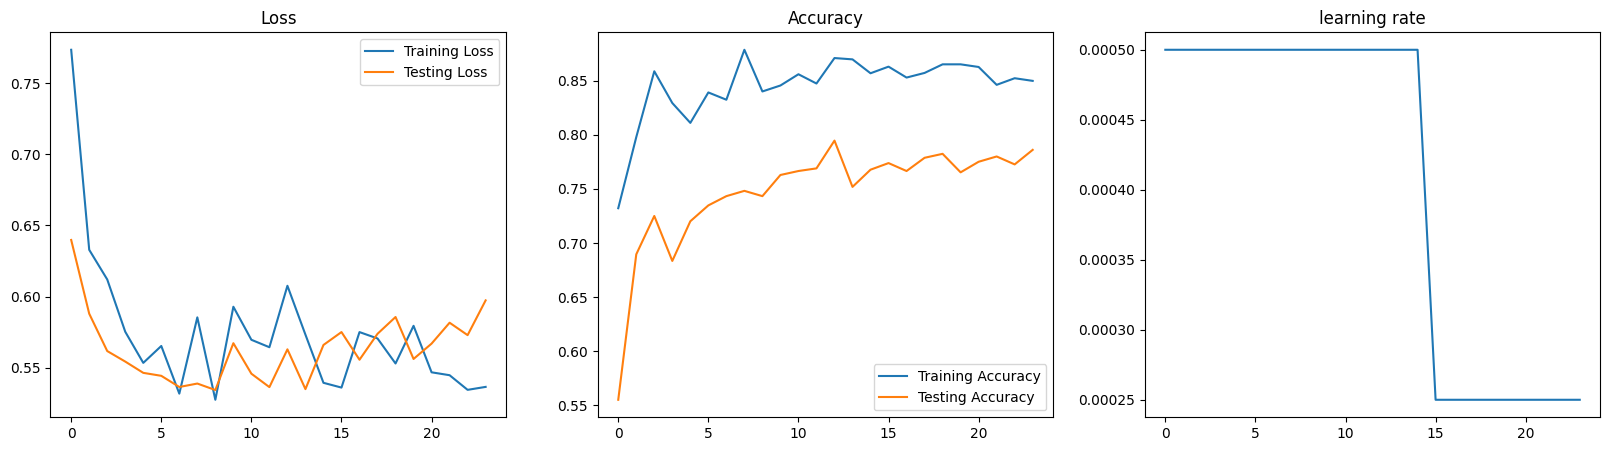

In [235]:
# 視覺化訓練過程
plt.figure(figsize=(20, 5))

# 繪製 Training loss 和 Validation loss
plt.subplot(131)
plt.plot(range(len(Train_loss)), Train_loss, label='Training Loss')
plt.plot(range(len(valid_loss)), valid_loss, label='Testing Loss')
plt.legend(loc='best')
plt.title('Loss')

# 繪製 Training accuracy 和 Validation accuracy
plt.subplot(132)
plt.plot(range(len(Train_acc)), Train_acc, label='Training Accuracy')
plt.plot(range(len(valid_acc)), valid_acc, label='Testing Accuracy')
plt.legend(loc='best')
plt.title('Accuracy')

# 繪製 Training accuracy 和 Validation accuracy
plt.subplot(133)
plt.plot(range(len(lr_rate)), lr_rate, label='learning rate')
plt.title('learning rate')

plt.show()

In [236]:
# 使用標準化後的驗證資料進行預測
# 確保資料格式正確
val_data_tensor = X_val_scaled.values.astype(np.float32)
val_data_tensor = np.where(np.isfinite(val_data_tensor), val_data_tensor, 0)

Model_X_test = torch.from_numpy(val_data_tensor).to(device)
y_test_pred = model(Model_X_test)
y_test_pred = y_test_pred.cpu().data.numpy()
y_test_pred_id = np.argmax(y_test_pred, axis=-1)

In [237]:
report = classification_report(y_pred = y_test_pred_id, y_true = y_val)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.79      0.88       778
           1       0.14      0.65      0.23        40

    accuracy                           0.79       818
   macro avg       0.56      0.72      0.55       818
weighted avg       0.94      0.79      0.84       818



In [238]:
cnfm = confusion_matrix(y_pred = y_test_pred_id, y_true = y_val)
cnfm = pd.DataFrame(cnfm, columns=['Pred_0', 'Pred_1'], index=['Act_0', 'Act_1'])
cnfm

,Pred_0,Pred_1
Act_0,617,161
Act_1,14,26


In [239]:
# 載入最佳模型進行預測
model.load_state_dict(torch.load(model_path))
model.eval()

# 對測試資料進行預測 - 使用標準化後的資料
with torch.no_grad():
    # 確保測試資料格式正確
    test_data_tensor = X_test_scaled.values.astype(np.float32)
    test_data_tensor = np.where(np.isfinite(test_data_tensor), test_data_tensor, 0)
    
    Model_test = torch.from_numpy(test_data_tensor).to(device)
    y_test_pred = model(Model_test)
    y_test_pred = y_test_pred.cpu().data.numpy()
    y_test_pred_id = np.argmax(y_test_pred, axis=-1)

# 讀取原始測試資料的 ID
test_ids = data_test['id'].values

# 建立預測結果的 DataFrame
submission = pd.DataFrame({
    'id': test_ids,
    'stroke': y_test_pred_id
})

# 輸出為 CSV 檔案
submission.to_csv('./data/solution.csv', index=False)
print("預測結果已儲存至 ./data/solution.csv")

預測結果已儲存至 ./data/solution.csv


## Inference

In [240]:
test = pd.read_csv('./data/test.csv', index_col=False)

In [241]:
# test資料前處理

In [242]:
# test資料前處理 - 使用標準化後的資料
# 確保資料格式正確
test_data_tensor = X_test_scaled.values.astype(np.float32)
test_data_tensor = np.where(np.isfinite(test_data_tensor), test_data_tensor, 0)

Model_test = torch.from_numpy(test_data_tensor).to(device)
y_test_pred = model(Model_test)
y_test_pred = y_test_pred.cpu().data.numpy()
y_test_pred_id = np.argmax(y_test_pred, axis=-1)

In [243]:
sol = pd.read_csv(f'./data/solution.csv', header=0)

In [244]:
report = classification_report(y_pred = y_test_pred_id, y_true = sol['stroke'])
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       806
           1       1.00      1.00      1.00       216

    accuracy                           1.00      1022
   macro avg       1.00      1.00      1.00      1022
weighted avg       1.00      1.00      1.00      1022



In [245]:
cnfm = confusion_matrix(y_pred = y_test_pred_id, y_true = sol['stroke'])
cnfm = pd.DataFrame(cnfm, columns=['Pred_0', 'Pred_1'], index=['Act_0', 'Act_1'])
cnfm

,Pred_0,Pred_1
Act_0,806,0
Act_1,0,216


In [246]:
# 診斷標準化後的資料品質
print("=== 資料品質檢查 ===")
print("訓練資料:")
print(f"  形狀: {X_train_scaled.shape}")
print(f"  NaN 數量: {X_train_scaled.isnull().sum().sum()}")
print(f"  無窮大數量: {np.isinf(X_train_scaled.select_dtypes(include=[np.number])).sum().sum()}")

print("\n驗證資料:")
print(f"  形狀: {X_val_scaled.shape}")
print(f"  NaN 數量: {X_val_scaled.isnull().sum().sum()}")
print(f"  無窮大數量: {np.isinf(X_val_scaled.select_dtypes(include=[np.number])).sum().sum()}")

print("\n測試資料:")
print(f"  形狀: {X_test_scaled.shape}")
print(f"  NaN 數量: {X_test_scaled.isnull().sum().sum()}")
print(f"  無窮大數量: {np.isinf(X_test_scaled.select_dtypes(include=[np.number])).sum().sum()}")

# 檢查標準化的數值特徵
numerical_cols = ['age', 'avg_glucose_level', 'bmi', 'chronic_diseases', 'multiple_risks', 'high_risk_age']
print(f"\n標準化後數值特徵統計 (前5個):")
for col in numerical_cols[:3]:
    print(f"{col}: mean={X_train_scaled[col].mean():.4f}, std={X_train_scaled[col].std():.4f}")

=== 資料品質檢查 ===
訓練資料:
  形狀: (3270, 37)
  NaN 數量: 0
  無窮大數量: 0

驗證資料:
  形狀: (818, 37)
  NaN 數量: 0
  無窮大數量: 0

測試資料:
  形狀: (1022, 37)
  NaN 數量: 0
  無窮大數量: 0

標準化後數值特徵統計 (前5個):
age: mean=0.0000, std=1.0002
avg_glucose_level: mean=0.0000, std=1.0002
bmi: mean=-0.0000, std=1.0002
